#### About
Camera projection matrix for mapping real world 3D cartesian coordinates to Image plane and vice versa.

1. Primary assumption is that all the following concepts are applicable for Pinhole camera.
2. x = PX is the equation to map a 2D pixel coordinate to 3D world coordinate where x is 2D pixel coordinate, P is projection matrix and X is 3D world coordinate.
3. Four coordinate systems that are involved include world, camera, image plane and sensor coordinate system.
4. Initially, The camera needs to be localised in the real world coordinate system.
5. The camera location is defined by the projection center followed by the rotational matrix. 
6. Projection matrix is comprised of 11 degrees of freedom - 6 degrees of freedom for camera extrinsic and 5 including distortion parameter for camera intrinsic.
7. It's described in the image below
![img.jpg](img.jpg)
8. We cannot easily invert Projection matrix as there is a loss of information while projecting 3D image to 2D.
9. Camera Extrinsic and Camera Intrinsic are parameter of a camera model. The Extrinsic describe the localisation of the camera in real world (Rotational and Translation).
10. Camera Intrinsic comprises of Camera constant(C- Distance of image plane to projection center), m - scale diff between x and y along with fx,fy(focal length), px,py(principal point) and distortion parameter(S- Shear parameter) describe how an image in 3D is mapped to 2D.
11. Camera Calibration is a technique used for calculating intrinsic parameter of the image.
12. Homogeneous coordinates are coordinates system for projective geometry. They allow us to express transformations elegantly for camera model. They can express transformation as matrices and also express points at infinity.
13. To convert a point [x,y] in euclidean space, Add a third dimension by adding 1 to it to transform it to homogeneous space [x,y,1]
14. To convert a point [x,y,z] from homogenous space to euclidean, divide it by z and remove the 1 i.e [x/z,y/z]
15. Scaled versions of [x,y,1] are equal in homogeneous space i.e [nx,ny,n] is space
16. [x,y,0] are points at infinity i.e setting last component as 0.

In [90]:
# code for projecting point cloud
import numpy as np

def project_pointcloud(point_cloud,rot,trans, f, s_x,s_y, s_theta, theta_x, theta_y):
    #converting 3D point cloud to homogeneous coordinate and transposing it
    homogeneous_pointcloud = np.hstack((point_cloud,np.ones((point_cloud.shape[0],1)))).T
    perspective_projection = np.eye(3,4)

    # se matrix containing rotation and translation of the camera
    se = np.zeros((4,4))
    se[:3,:3] = rot
    se[-1,-1]=1
    se[:3,-1] = -trans # T is the camera position in the frame hence -ve sign is added

    #building up the intrinsic parameter matrxi
    k = np.zeros((3,3))
    k[0,0] = f* s_x
    k[0,1] = f*s_theta
    k[1,1] = f* s_y
    k[0,2] = theta_x
    k[1,2] = theta_y
    k[2,2] = 1

    #performing matrix mult to get proj matrix
    proj_matrix = k @ perspective_projection @ se

    #getting depth of points with respect to camer5a
    pc_cam_frame = se @ homogeneous_pointcloud
    depths = pc_cam_frame[2,:]

    # project point cloud onto pixel coordinates of the image

    pc_pixel = (proj_matrix @ homogeneous_pointcloud)/depths  #x= PX

    return np.rint(pc_pixel)[0:2,:].T

In [91]:
def project_pc(pc, R, T, f, s_x, s_y, s_theta, theta_x, theta_y):
    # convert 3D pc to homogeneus coordinates and transpose it
    # pc_homog is then a 3xN matrix
    pc_homog = np.hstack((pc, np.ones((pc.shape[0], 1)))).T
    persp_proj = np.eye(3, 4)

    # se matrix containing rotation and tranlation of the camera (element of the special euclidean group)
    se = np.zeros((4, 4))
    se[:3, :3] = R
    se[-1,-1] = 1
    se[:3, -1] = -T # careful: T is the camera position in the origin frame, this is why we add a minus

    # Construct intrinsic parameter matrix K
    K = np.zeros((3, 3))
    K[0, 0] = f * s_x
    K[0, 1] = f * s_theta
    K[1, 1] = f * s_y
    K[0, 2] = theta_x
    K[1, 2] = theta_y
    K[2, 2] = 1

    K_all = K @ persp_proj @ se

    # get depths of points w.r.t camera
    pc_cam_frame = se @ pc_homog
    depths = pc_cam_frame[2, :]

    # project point clooud onto pixel coordinates of the image
    pc_pixel = (K_all @ pc_homog)/depths

    return np.rint(pc_pixel)[0:2, :].T

In [101]:
#reading point cloud
import open3d as o3d
import matplotlib.pyplot as plt

pc = o3d.io.read_point_cloud('cube.ply')
o3d.visualization.draw_geometries([pc])

In [104]:
#uncolored point cloud
points = np.asarray(pc.points)
x,y,z = [],[],[]
for i in range(len(points)):
    x.append(points[i][0])
    y.append(points[i][1])
    z.append(points[i][2])

x = np.asarray(x)
y = np.asarray(y)
z = np.asarray(z)

In [105]:
# it's an uncolored point cloud
colors = np.asarray(pc.colors)
green,red,blue = [],[],[]
for i in range(len(points)):
    green.append(points[i][0])
    red.append(points[i][1])
    blue.append(points[i][2])

green = np.asarray(green)
red = np.asarray(red)
blue = np.asarray(blue)

In [106]:
pc = np.zeros((x.shape[0], 3))
pc[:, 0] = x
pc[:, 1] = y
pc[:, 2] = z

In [107]:
colors = np.zeros((x.shape[0], 3))
colors[:, 0] = red
colors[:, 1] = green
colors[:, 2] = blue

In [108]:
#defining the translation and rotational matrices
Trans = np.array([-1.6, -1.2, -1])
Rot = np.array([[0, -1, 0],
              [1, 0, 0],
              [0, 0, 1]])


In [109]:
f = 1000*3
s_x = 1
s_y = 1
s_theta = 0.5
theta_x = 2000
theta_y = 2000

In [110]:
p_pixel = project_pointcloud(pc, Rot, Trans, f, s_x, s_y, s_theta, theta_x, theta_y)
p_pixel = p_pixel.astype(int)
p_pixel


array([[ 8600,  5600],
       [ 5300,  3800],
       [ 3800,  3800],
       [ 5600,  5600],
       [10100,  8600],
       [ 6050,  5300],
       [ 4550,  5300],
       [ 7100,  8600]])

In [111]:
img = np.zeros((p_pixel[:, 1].max()+1, p_pixel[:, 0].max()+1, 3))


In [112]:
for index, cur_pixel in enumerate(p_pixel):
    img[cur_pixel[1], cur_pixel[0], 0] = red[index]
    img[cur_pixel[1], cur_pixel[0], 1] = green[index]
    img[cur_pixel[1], cur_pixel[0], 2] = blue[index]

In [113]:
img

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 1., 0.]]])

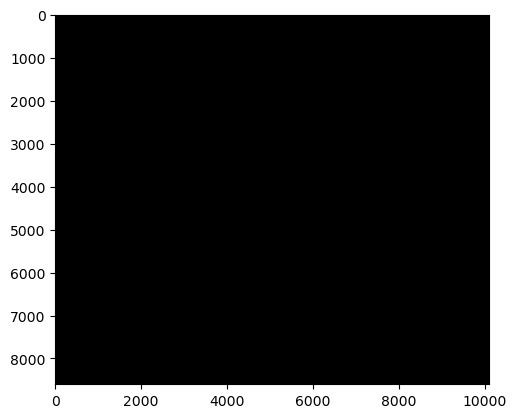

In [114]:
plt.imshow(img.astype(np.uint8), cmap='gray')